# Проект для "Викишоп"

# Содеражение

- [1. Введение](#1.)
- [1.1. Описание проекта](#1.1.)
- [1.2. Описание данных](#1.2.)
- [1.3. Импорт библиотек](#1.3.)
- [2. Чтение данных](#2.)
- [3. Обработка данных](#3.)
- [4. Машинное обучение](#4.)
- [4.1. Логистическая регрессия](#4.1.1.)
- [4.1.1. Логистическая регрессия на TFIDF](#4.1.1.)
- [4.1.2. Логистическая регрессия на мешке слов без фильтрации стоп-слов](#4.1.2.)
- [4.1.3. Логистическая регрессия на мешке слов с фильтрацией стоп-слов](#4.1.3.)
- [5. Выводы](#5.)

# 1. Введение <a id="1."></a>

**Цель**: изучить подходы к классификации текстов с помощью машинного обучения.

**Задача**: сравнить качество прогноза для различных методов векторизации текста: TFIDF и мешок слов "с" и "без" фильтации стоп слов на логистической регрессии. 

## 1.1. Описание проекта <a id="1.1."></a>

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.
Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.
Постройте модель со значением метрики качества F1 не меньше 0.75.

## 1.2. Описание данных <a id="1.2."></a>

- Столбец *text* содержит текст комментария.
- Столбец *toxic* содержит целевой признак.

## 1.3. Импорт библиотек <a id="1.3."></a>

In [114]:
import numpy as np
import pandas as pd
import os
import re
import sys

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import nltk
nltk.download('stopwords') 
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alsta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alsta\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 2. Чтение даных <a id="2."></a>

In [3]:
path1 = 'toxic_comments.csv'
path2 = '/datasets/toxic_comments.csv'

if os.path.exists(path1):
    df = pd.read_csv(path1)
elif os.path.exists(path2):
    df = pd.read_csv(path1)
else: print('не найден путь')

In [4]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


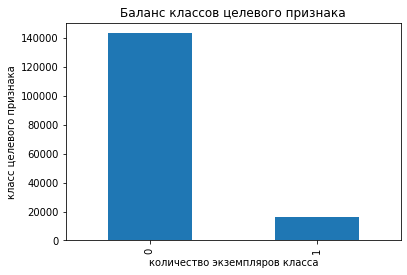

In [15]:
ax = df['toxic'].value_counts().plot(kind='bar', title = "Баланс классов целевого признака")
ax.set(xlabel = 'количество экземпляров класса', ylabel = 'класс целевого признака')
plt.show()

На лицо дисбаланс классов. Хорошо, что в логистической регрессии есть параметр class_weight. Надо не забыть его выставить в 'balanced'. 

In [39]:
# для оценки занимаемого объема памяти преобразуем в numpy c перекодировкой в юникод
corpus_unicode = df['text'].values.astype('U')
#ну и для дела (дальнийших операций) - без преобразования в юникод
corpus = df['text'].values #.astype('U')

In [46]:
print(f'объем памяти датасета в формате юникод занимает {round(corpus_unicode.nbytes/1024/1024,2)} МБ')
print(f'объем памяти датасета в исходном формате ({corpus.dtype}) занимает {round(corpus.nbytes/1024/1024,2)} МБ')

объем памяти датасета в формате юникод занимает 3043.58 МБ
объем памяти датасета в исходном формате (object) занимает 1.22 МБ


# 3. Обработка данных <a id="3."></a>

на данном этапе выполним очистку и лематтизацию текста

In [48]:
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\alsta\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\alsta\AppData\Roaming\nltk_data...
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alsta\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [66]:
# создадим "лемматизатор" и "очиститель"

# заиспользуем функцию из доки по ссылке целиком. может когда и другие части дикта пригодятся
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize(word):
    m = WordNetLemmatizer()
    try:
        lemm_word = m.lemmatize(word, get_wordnet_pos(word))
        return "".join(lemm_word)
    except:
        return  'lemmatization_error'

def clear_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    return ' '.join(text.split())

In [70]:
# проверим как работает
test_text = "he goes with rabbits. They are happy."
print(f'текст "{test_text}" преобразуется в :'," ".join([lemmatize(word) for word in clear_text(test_text).split()]))
print('лемматизация с pos-тегами отрабатывает корректно')

текст "he goes with rabbits. They are happy." преобразуется в : he go with rabbit They be happy
лемматизация с pos-тегами отрабатывает корректно


Очистим и лемматизируем текст

In [72]:
%%time
df['lemm_text'] = df['text'].apply(lambda text: (" ".join([lemmatize(word) for word in clear_text(text).split()])))

Wall time: 3h 37min 12s


Без pos - тегов лемматизировалось порядка 2-х минут. С ними немного подольше.. 3 часа 37 минут ..) 

# 4. Машинное обучение <a id="4."></a>

In [75]:
# сохраним лемматизированный текст. почти три часа вычислений как никак..
df.to_csv('lemmatized.csv', index=False)

## 4.1. Логистическая регрессия <a id="4.1."></a>

В данном пункте оценим влияние на предиктивную способность модели способа векторизации текстов. Оценим следующие способы векторизации:
- TFIDF с отфильтрованными стоп-словами
- мешок слов так же с отфильтрованными стоп-словами
- мешок слов без фильтрации стоп-слов

Разобьем датасет на фичи и целевой признак 

In [115]:
features = df['lemm_text'].values
target = df['toxic']

...и на тренировочную и тестовую выборки

In [116]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.1, random_state = 42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(143613,)
(15958,)
(143613,)
(15958,)


## 4.1.1. Логистическая регрессия на TFIDF <a id="4.1.1."></a>

In [118]:
%%time
#зададим список стоп-слов

# инициализируем обьект класса TfidfVectorizer
count_tf_idf = TfidfVectorizer(stop_words=stopwords, ngram_range = (2,2))
# методом fit_transform выполним TFIDF обучение и преобразование треничровочной выборки
tf_idf_train = count_tf_idf.fit_transform(X_train)
# пр помощи обученного на тренировочной выборке объекта преобразуем тестовую выборку 
tf_idf_test = count_tf_idf.transform(X_test)
print("Размер тренировочной TFIDF матрицы с фильтрацией стоп-слов:", tf_idf_train.shape)
print("Размер тестовой TFIDF матрицы с фильтрацией стоп-слов:", tf_idf_test.shape)

Размер тренировочной TFIDF матрицы с фильтрацией стоп-слов: (143613, 2190602)
Размер тестовой TFIDF матрицы с фильтрацией стоп-слов: (15958, 2190602)
Wall time: 46.4 s


In [99]:
%%time
model = LogisticRegression(random_state = 42, max_iter = 750, class_weight='balanced')
model.fit(tf_idf_train, y_train)
predicted_1 = model.predict(tf_idf_test)
f1_score_1 = f1_score(predicted_1, y_test)
print('score для tf_idf = ', f1_score_1)

score для tf_idf =  0.5696571845368344
Wall time: 1min 15s


Кажется ngram_range = (2,2) пользы не принесла. Ну чтож попробовали хотя бы.. Оставим как есть. Идем дальше

## 4.1.2. Логистическая регрессия на мешке слов без фильтрации стоп-слов <a id="4.1.2."></a>

In [120]:
%%time
#corpus = df['lemm_text'].values.astype('U')
count_vect = CountVectorizer()
big_bow_train = count_vect.fit_transform(X_train)
big_bow_test = count_vect.transform(X_test)

print("Размер тренировочного мешка без учёта стоп-слов:", big_bow_train.shape)
print("Размер тестового мешка без учёта стоп-слов:", big_bow_test.shape)

Размер тренировочного мешка без учёта стоп-слов: (143613, 150784)
Размер тестового мешка без учёта стоп-слов: (15958, 150784)
Wall time: 20.4 s


In [121]:
%%time
model = LogisticRegression(random_state = 42, max_iter = 750, class_weight='balanced')
model.fit(big_bow_train, y_train)
predicted_2 = model.predict(big_bow_test)
f1_score_2 = f1_score(predicted_2, y_test)
print('score для tf_idf = ', f1_score_2)

score для tf_idf =  0.7709724238026124
Wall time: 1min 15s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## 4.1.3. Логистическая регрессия на мешке слов с фильтрацией стоп-слов <a id="4.1.3."></a>

In [122]:
%%time
 
count_vect = CountVectorizer(stop_words = stopwords)
small_bow_train = count_vect.fit_transform(X_train)
bow_small_test = count_vect.transform(X_test)

print("Размер тренировочного мешка с учётом фильтра стоп-слов:", small_bow_train.shape)
print("Размер тестового мешка с учётом фильтра стоп-слов:", bow_small_test.shape)

Размер тренировочного мешка с учётом фильтра стоп-слов: (143613, 150639)
Размер тестового мешка с учётом фильтра стоп-слов: (15958, 150639)
Wall time: 18.6 s


In [123]:
%%time
# Здесь и далее по тексту (кода) не забудем учесть весьма существенный дизбаланс классов.
model = LogisticRegression(random_state = 42, max_iter = 750, class_weight='balanced')
model.fit(small_bow_train, y_train)
predicted_3 = model.predict(bow_small_test)
f1_score_3 = f1_score(predicted_3, y_test)
print('score для tf_idf = ', f1_score_3)

score для tf_idf =  0.7623188405797102
Wall time: 47.9 s


In [83]:
print('длина списка стоп-слов равна', big_bow_train.shape[1] - small_bow_train.shape[1])
print('прирост качества прогноза без использовании списка стоп-слов составляет', f1_score_2 - f1_score_3)

длина списка стоп-слов равна 145
прирост качества прогноза без использовании списка стоп-слов составляет 0.008653583222902217


**Резюме:** необходимый порог дважды пройден! Йеее! 🤘  Но что удивительно - TFIDF дало результат хуже. Видимо она заточена на улавливание нюансов в большом тексте на большом корпусе текстов, а в коротких твитах, видимо, или токсичные слова встречаются или нет. 


# 5. Выводы <a id="5."></a>

**Что сделано**

В рамках настоящего проекта было проведено исследование методов токенизации текстов тремя способами:
    - TFIDF с отфильтрованными стоп-словами cо значением n-грамм = 2
    - мешок слов так же с отфильтрованными стоп-словами
    - мешок слов без фильтрации стоп-слов


**Очистка и лемматизация**
Перед разбивкой датасета были подготовлены функции для очистки текстов через регулярные выражения и лемматизации (приведению к начальной форме) полученных слов и соответственно проведена очистка и лемматизация текста. Лемматизация проведена на базе WordNetLemmatizer библиотеки nltk (модуль stem). Время данного этапа без POS-тегов составило порядка 2-х минут, а с POS-тегами 3 часа 37 минут. 

**Токенизация** 
Как сказано выше было проведено три способа токенизации, время для способов токенизации без разбиения на n-граммы - до 30 сек. С разбиением - порядка 45.

**Машинное обучение**
Машинное обучение было проведено с применением Логистической регрессии для каждого из 3-х способв токенизации, так же была попытка обучить Случайный лес, которая успеха не принесла. 

**Логистическая регрессия**
Для логистической регрессии наилучший результат дала токенизация методом мешка слов и при этом без фильтрации стоп-слов. Регрессия достигла требуемого порога 0.75 и дала результат f1 = 0.7709. Здесь стоит отметить, что при лемматизации без POS-тегов (было выполнено в предыдущей версии проекта) f1 была равен = 0.7789.   При этом время на обучение составило менее 30 сек. В процессе обучения ввиду выпавшего ворнинга опытным путем было поднято значение max_iter до 750, что убрало "ворнинги" и увеличило результат. При обучении на TFIDF было применено разбиение на n-граммы, что дало результат хуже, ввиду далее этот подход не применылся. 

**Случайный лес** - В рамках данного проекта была проведена попытка обучить Случайный лес, но по причине отсутствия результата код для обучения и прогноза исключен из "ноутбука". Случайный лес обучался более 2-х часов на мешке слов без фильтрации стоп-слов и дал результат f1=0.

**Выводы**
1. Различные способы токенизации корпуса текстов дают различные результаты прогноза, при этом надежда, что TFIDF даст лучший результат не оправдалась.
2. Лемматизация с POS-тегами улучшения результат не принесла, но иметь ввиду такую возможность надо.
3. Разбинение на n-граммы результат ухудшило, но хотя бы попробовали..
2. Для NLP, видимо, подходят не все модели, при этом регрессия дала приемлемый результат при минимальных затратах.